In [ ]:
import pandas as pd
import gdown

file_id = "1Xm3HWAnrHjLmvPTMVIMW4q624SBr_SCH"
url = f"https://drive.google.com/uc?id={file_id}"

output = "dataset.csv"  # Adjust the filename and extension if needed

gdown.download(url, output, quiet=False)
print(f"File downloaded as {output}")

In [ ]:
df = pd.read_csv("dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,0
review,0
sentiment,0


In [ ]:
pos = df[df["sentiment"] == "positive"]
neg = df[df["sentiment"] == "negative"]

pos = pos[:3000]
neg = neg[:3000]

df = pd.concat([pos, neg])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
positive,3000
negative,3000


::# Dataset Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

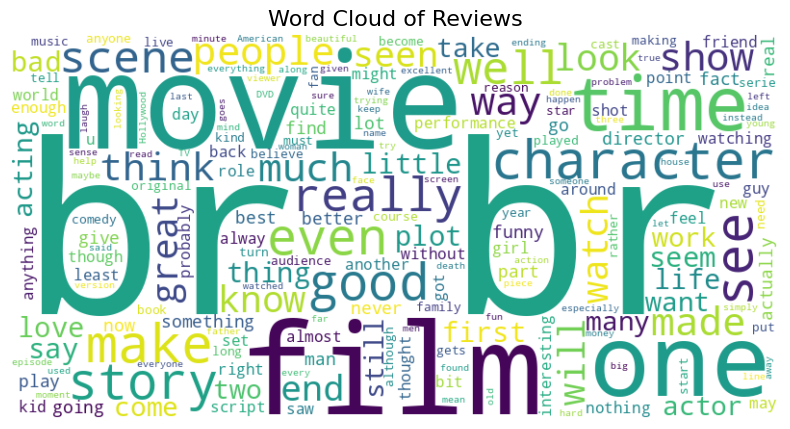

In [ ]:
from wordcloud import WordCloud

text = " ".join(review for review in df["review"].astype(str))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Reviews", fontsize=16)
plt.show()

In [ ]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\bbr\b", "", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text).strip()
    return text
df["review"] = df["review"].astype(str).apply(clean_text)

In [ ]:
df["review"].head()

,review
0,one of the other reviewers has mentioned that ...
1,a wonderful little production the filming tech...
2,i thought this was a wonderful way to spend ti...
4,petter matteis love in the time of money is a ...
5,probably my alltime favorite movie a story of ...


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["review"] = df["review"].astype(str).apply(preprocess_text)
df["review"].head()

,review
0,one reviewer mentioned watching 1 oz episode y...
1,wonderful little production filming technique ...
2,thought wonderful way spend time hot summer we...
4,petter matteis love time money visually stunni...
5,probably alltime favorite movie story selfless...


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import torch

# Tokenizer and dataset preparation
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

train, test = train_test_split(df, test_size=0.3, stratify=df['sentiment'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['sentiment'])

dataset = DatasetDict({
    "train": Dataset.from_pandas(train, preserve_index=False),
    "test": Dataset.from_pandas(test, preserve_index=False),
    "validation": Dataset.from_pandas(validation, preserve_index=False)
})

def tokenize(batch):
    return tokenizer(batch['review'], padding=True, truncation=True, return_token_type_ids=True)

emotion_encoded = dataset.map(tokenize, batched=True)

label2id = {label: i for i, label in enumerate(dataset['train'].unique('sentiment'))}
id2label = {i: label for label, i in label2id.items()}

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to("cuda" if torch.cuda.is_available() else "cpu")

# Training arguments
training_args = TrainingArguments(
    output_dir="bert_base_training_dir",
    overwrite_output_dir=True,
    num_train_epochs=1,
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotion_encoded['train'],
    eval_dataset=emotion_encoded['validation'],
    tokenizer=tokenizer
)

Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 90.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 10124 has 14.73 GiB memory in use. Of the allocated memory 14.58 GiB is allocated by PyTorch, and 28.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
trainer.train()

In [ ]:
metrics = trainer.evaluate(emotion_encoded['test'])
print(metrics)

In [ ]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

In [ ]:
preds_output.predictions

In [ ]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

In [ ]:
label2id

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt ='d', cbar=False, cmap='Reds')
plt.yabel("Actual")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.show()

#Build Prediction function and save model

In [ ]:
text = "I am super happy today. I got it done. Finally!!"
def get_prediction (text) :
    input_encoded = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
      outputs = model(**input_encoded)
    logits = outputs. logits
    pred = torch.argmax(logits, dim=1) .item()
    return id2label[pred]
get_prediction (text)

In [ ]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [ ]:
# use pipeline for prediciton
from transformers import pipeline
classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model')
classifier([text, 'A very good day indeed', "We loved mth111", "I am feeling anxious"])

In [ ]:
# make a file app.py, and use this code


# import streamlit as st
# from transformers import pipeline

# st.title("Fine-Tuning BERT for Twitter Sentiment Classification")

# classifier = pipeline('text-classification', model='bert-base-uncased-sentiment-model')

# text = st.text_area("Enter Your Tweet Here")

# if st.button("Predict"):
#         result = classifier(text)
#         st.write("Prediction Result:", result)

#